# Preprocessing Training/testing Data

In [ ]:
import pandas as pd
from openpyxl import load_workbook
file = load_workbook('abstract_screening.xlsx', read_only=True, keep_links=False)
sheet_names = file.sheetnames
print(sheet_names)

all_sheets = []
for sheet in sheet_names:
    sub_df = pd.read_excel("abstract_screening.xlsx", sheet_name=sheet)
    all_sheets.append(sub_df)

df = pd.read_excel("abstract_screening.xlsx", sheet_name='HVW')

In [3]:
import pandas as pd
df = pd.read_excel("abstract_screening.xlsx", sheet_name='HVW')
df.to_excel("V1_abstract_screening.xlsx", index=False)

In [2]:
df_train = df.drop(columns=['included', 'article_type'])
df_test = df[['short_id', 'included']]

In [ ]:
import sklearn
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(df_train, df_test, test_size=0.2, random_state=42)

In [4]:
X_train_llm = X_train[:200]
y_train_llm = y_train[:200]

In [ ]:
title = ground_truth_df.loc[ground_truth_df.short_id == 5186].title



In [12]:
ground_truth_df.loc[ground_truth_df.short_id == 5186]

,short_id,eid,doi,weblink,scholar_link,journal,author_names,year,title,abstract,included,article_type
59,5186,2-s2.0-78649776398,10.1080/07491409.2006.10757628,https://doi.org/10.1080/07491409.2006.10757628,https://scholar.google.com/scholar?q=10.1080/0...,Women's Studies in Communication,"Peeples, Jennifer A.;DeLuca, Kevin M.",2006,"The truth of the matter: Motherhood, community...",Armed with their personal experiences and comm...,no,-


In [5]:
ground_truth_df = pd.read_excel("V1_abstract_screening.xlsx")
ground_truth_df.iloc[ground_truth_df['short_id'] == 5186]

NotImplementedError: iLocation based boolean indexing on an integer type is not available

# LLM Screening Agent

In [ ]:
from openai import OpenAI
from IPython.display import display, HTML
from concurrent.futures import ThreadPoolExecutor, as_completed
import time
import main_prompt
import os
from dotenv import load_dotenv
response_content = []
full_api_response = []

#MODEL = 'gpt-oss-120b'
#MODEL = "meta-llama-3.1-8b-instruct"

def get_relevance_score(abstract, title, short_id, previous_system_prompt_file_path, previous_user_prompt_file_path):
    load_dotenv()
    API_KEY = os.getenv("API_KEY")
    api_key = API_KEY # Replace with your API key
    base_url = "https://chat-ai.academiccloud.de/v1"
    MODEL = 'openai-gpt-oss-120b' #'gemma-3-27b-it'
    if not api_key:
        raise ValueError("API key is not set. Please set the API_KEY environment variable.")
    client = OpenAI(api_key = api_key, base_url = base_url)

    file1 = open(previous_system_prompt_file_path, 'r')
    original_system_prompt = file1.read()
    file1.close()

    file2 = open(previous_user_prompt_file_path, 'r')
    original_user_prompt = file2.read()
    file2.close()

    user_prompt = original_user_prompt.format(ABSTRACT=abstract, TITLE=title)
    chat_completion = client.chat.completions.create(messages=[{"role":"system","content": original_system_prompt},
                                                           {"role":"user","content": user_prompt}],
                                                           model=MODEL)

    output = chat_completion.choices[0].message.content.strip()
    time.sleep(1)
    response_content.append((output, short_id))
    full_api_response.append((chat_completion, short_id))
    time.sleep(8)
    print(f"Processed {short_id} with output: {output}")
    return output

# Example usage:
# df['Relevance Score'] = df['Abstract'].apply(get_relevance_score)

In [ ]:

X_train_llm_abstract['llm_decision'] = None
X_train_llm_abstract.iloc[:50, X_train_llm_abstract.columns.get_loc('llm_decision')] = X_train_llm_abstract.iloc[:50].apply(
    lambda row: get_relevance_score(row['abstract'], row['title'], row['short_id']),
    axis=1
)

In [23]:
llm_results_df = pd.concat([X_train_llm_abstract.iloc[:50], y_train_llm.iloc[:50]], axis=1)
llm_results_df.to_csv('llm_decision_comparison_50_hvw.csv', index=False)

## Load comparison Dataset

In [94]:
import pandas as pd
comparison_df = pd.read_csv('llm_decision_comparison_50_hvw2.csv')
iteration2_df = comparison_df[["abstract", "title", "short_id"]]
iteration2_df['new_vote'] = None
iteration2_df.iloc[:50, iteration2_df.columns.get_loc('new_vote')] = iteration2_df.apply(
    lambda row: get_relevance_score(row['abstract'], row['title'], row['short_id'],
                                    previous_system_prompt_file_path='./prompt_log/system_prompt_v2.txt',
                                    previous_user_prompt_file_path='./prompt_log/user_prompt_v2.txt'),
    axis=1
)
iteration2_df.to_csv('llm_decision_comparison_50_hvw_attempt2.csv', index=False)

/var/folders/0h/q4qdtr9j7g791902612bqpgh0000gn/T/ipykernel_37685/1935391354.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iteration2_df['new_vote'] = None


Processed 883 with output: Decision: EXCLUDE  
Reasoning: • The abstract’s primary focus is on mapping sea‑level rise policy preferences and nascent subsystem dynamics, not on environmental justice itself.  
• EJ is mentioned only as one of several issue dimensions considered by actors, without a dedicated EJ‑oriented framework, outcome analysis, or critique.
Processed 5186 with output: Decision: EXCLUDE  
Reasoning: • EJ is treated as a contextual backdrop for a study centered on gendered communication practices; the abstract lacks an EJ‑specific theoretical framework, empirical analysis of EJ disparities, or stratified methodology.  
• The primary focus is on motherhood and communicative tactics, not on EJ causes, outcomes, or policy analysis.
Processed 615 with output: Decision: INCLUDE  
Reasoning: • The abstract’s primary focus is on critical environmental justice theory and its global discourse, making EJ the central research subject.  
• It presents a substantive EJ engagement t

In [109]:
iteration2_false_clf = comparison_df.loc[comparison_df.y_true != comparison_df.y_pred]

In [97]:
import numpy as np
comparison_df = iteration2_df
comparison_df['vote'] = np.where(
    comparison_df['new_vote'].str.contains('INCLUDE', na=False),
    'INCLUDE',
    np.where(
        comparison_df['new_vote'].str.contains('EXCLUDE', na=False),
        'EXCLUDE',
        None
    )
)

In [ ]:
comp_df2 = pd.concat([iteration2_df, comparison_df[['included']]], axis=1)
comp_df2


In [104]:
comparison_df = comp_df2

# Evaluation

Confusion Matrix:
            Pred EXCLUDE  Pred INCLUDE
Actual no             17             6
Actual yes             2            25

True Positive (TP): 25
True Negative (TN): 17
False Positive (FP): 6
False Negative (FN): 2

Accuracy: 0.84
Precision: 0.81
Recall: 0.93


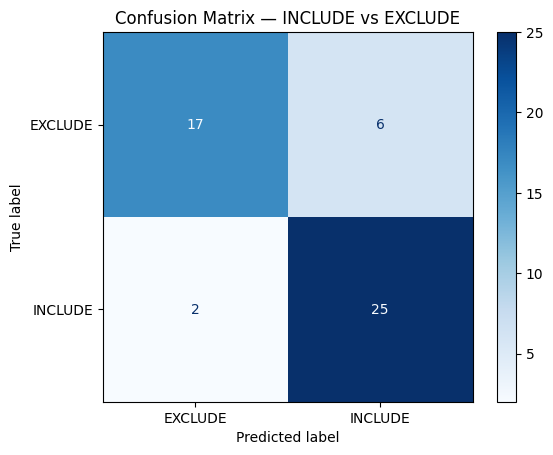

In [105]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

comparison_df['y_true'] = comparison_df['included'].map({'yes': 1, 'no': 0})
comparison_df['y_pred'] = comparison_df['vote'].map({'INCLUDE': 1, 'EXCLUDE': 0})

cm = confusion_matrix(comparison_df['y_true'], comparison_df['y_pred'])
TN, FP, FN, TP = cm.ravel()

accuracy = accuracy_score(comparison_df['y_true'], comparison_df['y_pred'])
precision = precision_score(comparison_df['y_true'], comparison_df['y_pred'])
recall = recall_score(comparison_df['y_true'], comparison_df['y_pred'])

print("Confusion Matrix:")
print(pd.DataFrame(cm, index=['Actual no','Actual yes'], columns=['Pred EXCLUDE','Pred INCLUDE']))
print()
print(f"True Positive (TP): {TP}")
print(f"True Negative (TN): {TN}")
print(f"False Positive (FP): {FP}")
print(f"False Negative (FN): {FN}")
print()
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['EXCLUDE', 'INCLUDE'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix — INCLUDE vs EXCLUDE')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

## Results Iteration 1

```
Confusion Matrix:
            Pred EXCLUDE  Pred INCLUDE
Actual no             13            10
Actual yes             1            26

True Positive (TP): 26
True Negative (TN): 13
False Positive (FP): 10
False Negative (FN): 1

Accuracy: 0.78
Precision: 0.72
Recall: 0.96
```

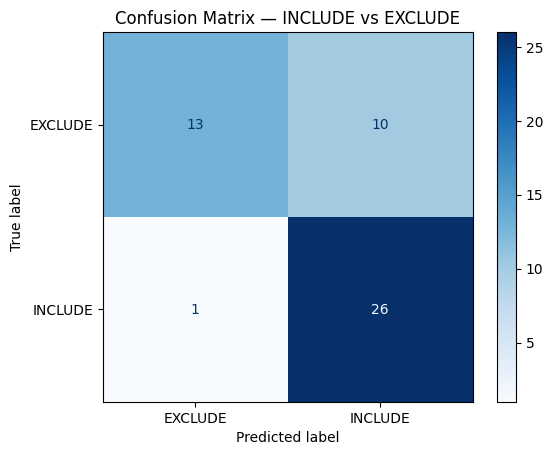

## Results Iteration 2

````
Confusion Matrix:
            Pred EXCLUDE  Pred INCLUDE
Actual no             17             6
Actual yes             2            25

True Positive (TP): 25
True Negative (TN): 17
False Positive (FP): 6
False Negative (FN): 2

Accuracy: 0.84
Precision: 0.81
Recall: 0.93
```

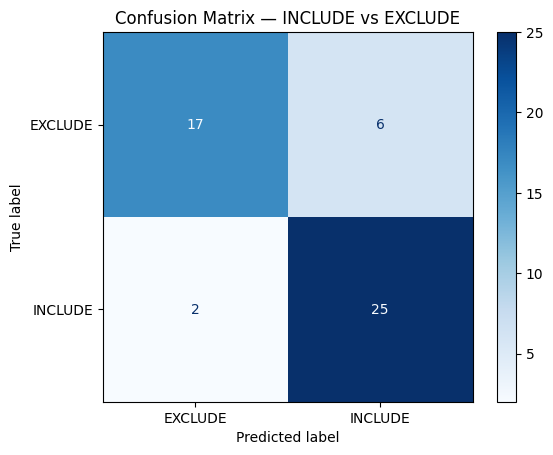

In [120]:
iteration2_false_clf = comparison_df.loc[comparison_df.y_true != comparison_df.y_pred]
iteration2_false_clf#.iloc[1].new_vote

,abstract,title,short_id,new_vote,vote,included,y_true,y_pred
11,© 2023 The Authors. GeoHealth published by Wil...,Community Health Impacts From Natural Gas Pipe...,867,Decision: INCLUDE \nReasoning: • The abstract...,INCLUDE,no,0,1
13,© 2022 Canadian Association of Geographers/L'A...,Site prioritization and the reproduction of in...,1816,Decision: INCLUDE \nReasoning: • EJ (environm...,INCLUDE,no,0,1
19,"© 2022, The Author(s), under exclusive licence...",Why do Mines Fail to Obtain a Social License t...,1017,Decision: INCLUDE \nReasoning: • The abstract...,INCLUDE,no,0,1
27,© 2021 Elsevier Inc.Research spanning several ...,"Inequality, information failures, and air poll...",2039,Decision: INCLUDE \nReasoning: • EJ is the ce...,INCLUDE,no,0,1
29,© 2021 The Author.Two concepts that bridge the...,Re-forming property to address eco-social frag...,1964,Decision: INCLUDE \nReasoning: • The abstract...,INCLUDE,no,0,1
44,© 2022 The Author. Antipode published by John ...,"Infrastructure, Development, and Displacement ...",1558,Decision: INCLUDE \nReasoning: • The abstract...,INCLUDE,no,0,1
46,The concept of 'environmental space' has been ...,"Sharing environmental space: The role of law, ...",5296,Decision: EXCLUDE \nReasoning: • EJ is mentio...,EXCLUDE,yes,1,0
49,© 2024 RSC.Ensuring environmental justice nece...,Enhancing spatial inference of air pollution u...,462,Decision: EXCLUDE \nReasoning: • EJ is mentio...,EXCLUDE,yes,1,0


## Accounting for misclassified ground truth

after multiple iterations some remaining classifications by the LLM still do not align with the ground truth. Using CoT reasoning we can look at why the LLM classified it accordingly and using Human in the Loop testing see wether or not some of the remaining articles might have been misclassified by the coder. In general, the line for what counts as included or excluded remains blurry. This leaves a blurry classification threshold, where including or excluding a paper can be seen as reasonable, if grounded by good arguments. Using reasoning supplied by the CoT approach we can determine wether or not these classifications are clearly false or not.

**Abstract 867:**
Title: 'Community Health Impacts From Natural Gas Pipeline Compressor Stations'

Abstract: '© 2023 The Authors. GeoHealth published by Wiley Periodicals LLC on behalf of American Geophysical Union.Compressor stations maintain pressure along natural gas pipelines to sustain gas flow. Unfortunately, they present human health concerns as they release chemical pollutants into the air, sometimes at levels higher than national air quality standards. Further, compressor stations are often placed in rural areas with higher levels of poverty and/or minority populations, contributing to environmental justice concerns. In this paper we investigate what chemical pollutants are emitted by compressor stations, the impacts of emitted pollutants on human health, and local community impacts. Based on the information gained from these examinations, we provide the following policy recommendations with the goal of minimizing harm to those affected by natural gas compressor stations: the Environmental Protection Agency (EPA) and relevant state agencies must increase air quality monitoring and data transparency; the EPA should direct more resources to monitoring programs specifically at compressor stations; the EPA should provide free indoor air quality monitoring to homes near compressor stations; the EPA needs to adjust its National Ambient Air Quality Standards to better protect communities and assess cumulative impacts; and decision-makers at all levels must pursue meaningful involvement from potentially affected communities. We find there is substantial evidence of negative impacts to strongly support these recommendations.'

Human Decision: 'EXCLUDE'

Agent Decision: 'INCLUDE'
Agent Reasoning:
- The abstract centers on the disproportionate health impacts of compressor stations on low‑income and minority communities, explicitly framing the issue as an environmental justice concern.
- It provides an empirical assessment of pollutant exposure and health outcomes stratified by socio‑economic/racial context and offers EJ‑focused policy recommendations.'

-- 


### My Personal opinion of Abtracts that were clearly falsely classified:

- abstract 5296 falsely classified as Exclude 
- abstract 1558 falsely classified as Include
- abstract 1964 falsely calssified as Include
- abstract 1816 falsely calssified as Include

If we assume the other not have been clear false classifications this would bring the total accuracy up to 92%.

## Intersting Points to note:

- at first the revised prompts have a very large effect on the improvement of the classifications
- the prompt understands the underlying intentions of the human more clearly by comparing ground truth with its own classification and tries to understand why it is false
    - the critial agent attempts to understand the **actual** intention of the human compared to what it wrote in the original Prompt.
    - the revision agent then attempts to edit the prompt in a way to reflect the actual intention of the human using the criticizm it got from the critical agent
    - the new prompt is then used to classify the articles. (on a structural level the question remains if the entire training set should be used or if it should be tested only on a subset of falsley classified ones)
    - additionally the question remains if this can be scaled to any additional abtract screening question or not (it might get complicated extracting all the text from papers for the full text coding. I could imagine that this step will have to be done manually. then the "reading" itself can maybe be done using a simple text extraction tool and a regular coding. However, this would use a significant amount of computing resources it would probably still be cheaper than letting student assisants do it.)


# Critic Agent

In [64]:
import critic_prompt

def critic_agent(comparison_df_row, previous_system_prompt_file_path, previous_user_prompt_file_path):
    load_dotenv()
    api_key = os.getenv("API_KEY")
    base_url = "https://chat-ai.academiccloud.de/v1"
    MODEL = 'openai-gpt-oss-120b' #'gemma-3-27b-it'
    client = OpenAI(api_key = api_key, base_url = base_url)

    file1 = open(previous_system_prompt_file_path, 'r')
    original_system_prompt = file1.read()
    file1.close()

    file2 = open(previous_user_prompt_file_path, 'r')
    original_user_prompt = file2.read()
    file2.close()

    print(comparison_df_row)
    user_prompt = critic_prompt.CRITIC_USER.format(
        TITLE=comparison_df_row.title, ABSTRACT=comparison_df_row.abstract, CHAIN_OF_THOUGHT=comparison_df_row.new_vote, 
        VOTE=comparison_df_row.vote, DECISION=comparison_df_row.ground_truth, SYSTEM_PROMPT=original_system_prompt, USER_PROMPT = original_user_prompt)
    chat_completion = client.chat.completions.create(messages=[{"role":"system","content": critic_prompt.CRITIC_SYSTEM},
                                                           {"role":"user","content": user_prompt}],
                                                           model=MODEL)

    output = chat_completion.choices[0].message.content.strip()
    time.sleep(1)

    return output

In [9]:
comparison_df["ground_truth"] = comparison_df['included'].map({'yes': 'INCLUDE', 'no': 'EXCLUDE'})
false_cases = comparison_df[comparison_df['vote'] != comparison_df['ground_truth']]

In [ ]:
test_row = false_cases.iloc[0]
critic_decision = critic_agent(test_row)
print(critic_decision)

**Failure diagnosis**  
The agent treated the presence of the phrase “women of Environmental Justice” and the discussion of “communicative practices” as evidence that environmental‑justice scholarship was the *central* focus of the paper. In fact, the abstract is principally about gendered identity (motherhood) and community‑based communication strategies; environmental‑justice is only a backdrop used to locate the women’s activism. No analytical framework, model, critique, or data‑driven EJ argument is presented. Consequently, the abstract does **not** satisfy the screening rule that EJ must be a substantive, central topic, and the correct label is **EXCLUDE**.

**Problematic assumption**  
The agent assumed that any explicit mention of “Environmental Justice” together with a social‑movement narrative automatically satisfies criterion (a) (EJ as a central topic) and criterion (b) (meaningful engagement). This conflates *contextual* mention of EJ with *theoretical or empirical* engagem

# Prompt revision Agent

In [67]:
import revision_prompt

def revision_agent(comparison_df_row, feedback, previous_system_prompt_file_path, previous_user_prompt_file_path):
    load_dotenv()
    api_key = os.getenv("API_KEY")
    base_url = "https://chat-ai.academiccloud.de/v1"
    MODEL = 'openai-gpt-oss-120b' #'gemma-3-27b-it'
    client = OpenAI(api_key = api_key, base_url = base_url)

    file1 = open(previous_system_prompt_file_path, 'r')
    original_system_prompt = file1.read()
    file1.close()

    file2 = open(previous_user_prompt_file_path, 'r')
    original_user_prompt = file2.read()
    file2.close()

    title = comparison_df_row.title
    abstract = comparison_df_row.abstract
    agent_reasoning = comparison_df_row.new_vote
    wrong_decision = comparison_df_row.vote
    correct_label = comparison_df_row.ground_truth

    critic_feedback = feedback 

    user_prompt = revision_prompt.REVISION_USER_PROMPT.format(
        title=title, abstract=abstract, agent_reasoning=agent_reasoning,
        wrong_decision=wrong_decision, correct_label=correct_label,
        critic_feedback=critic_feedback, original_system_prompt=original_system_prompt,
        original_user_prompt=original_user_prompt
    )
    system_prompt = revision_prompt.REVISION_SYSTEM_PROMPT

    chat_completion = client.chat.completions.create(messages=[{"role":"system","content": system_prompt},
                                                           {"role":"user","content": user_prompt}],
                                                           model=MODEL)

    output = chat_completion.choices[0].message.content.strip()
    time.sleep(1)

    return output

In [81]:

revised_prompts = revision_agent(comparison_df_row=test_row, feedback=critic_decision)
print(revised_prompts)

---REVISED SYSTEM PROMPT---
You are an experienced assistant in environmental justice (EJ) literature screening.  
Your task: classify whether each abstract should be **INCLUDED** or **EXCLUDED** based on the following criteria:

(a) **Primary focus** – EJ must be the main research focus of the paper, not just a contextual backdrop for a study whose core contribution lies in another discipline (e.g., gender studies, communication studies, cultural analysis). The abstract should center on EJ causes, consequences, policies, data, or theory.

(b) **Meaningful engagement** – The abstract must show substantive EJ engagement by providing at least one of the following:  
‑ an EJ‑oriented theoretical or analytical framework;  
‑ empirical analysis of EJ outcomes or disparities;  
‑ a critique of EJ policy or practice;  
‑ a methodological approach that explicitly stratifies results by EJ‑relevant variables (race, income, exposure, etc.).  
References to EJ only as motivation, background, or de

In [90]:
prompts = revised_prompts.split("PROMPT---")
system_prompt = prompts[1]
user_prompt = prompts[2]
print(user_prompt)



Decision format (only):
```
Decision: INCLUDE / EXCLUDE
Reasoning: • <one or two bullet points describing your decision logic>
```
Be strict:
- **INCLUDE** if the abstract’s main research question, objective, or argument is about EJ (its causes, consequences, policies, data, or theory) and demonstrates meaningful engagement as defined in criterion (b).  
- **EXCLUDE** if EJ is mentioned only as context or motivation for another primary focus (e.g., gender, identity, communication, culture) without an EJ‑specific framework, analysis, critique, or stratified methodology.  
- When uncertain, choose **EXCLUDE**.


# Checking improvment on false classifications

In [12]:
false_cases["new_vote"] = None
false_cases["new_vote"] = false_cases.apply(
    lambda row: get_relevance_score(row['abstract'], row['title'], row['short_id']), axis=1
)

/var/folders/0h/q4qdtr9j7g791902612bqpgh0000gn/T/ipykernel_37685/689956383.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_cases["new_vote"] = None


Processed 5186 with output: Decision: EXCLUDE  
Reasoning: • EJ is used as contextual backdrop for a study of communicative practices and gender roles, not as the primary research focus.  
• No explicit EJ‑oriented theoretical framework, empirical analysis of EJ outcomes, or stratified methodology is presented.
Processed 2979 with output: Decision: EXCLUDE  
Reasoning: • EJ is mentioned only as part of a broader discussion of social and environmental justice in the context of education policy, not as the central research focus.  
• The abstract lacks an EJ‑specific theoretical framework, empirical analysis, or methodological stratification of EJ variables.
Processed 3179 with output: Decision: EXCLUDE  
Reasoning: • The abstract’s primary focus is on the effects of external funding on planning education, with environmental justice treated only as a contextual element of a studio course. • It does not present a substantive EJ‑oriented framework, empirical analysis of EJ outcomes, or a d

/var/folders/0h/q4qdtr9j7g791902612bqpgh0000gn/T/ipykernel_37685/689956383.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_cases["new_vote"] = false_cases.apply(


In [ ]:
false_cases

,abstract,title,short_id,llm_decision,short_id.1,included,vote,y_true,y_pred,ground_truth,new_vote
1,Armed with their personal experiences and comm...,"The truth of the matter: Motherhood, community...",5186,Decision: INCLUDE \nReasoning:\n- EJ (environ...,5186,no,INCLUDE,0,1,EXCLUDE,Decision: EXCLUDE \nReasoning: • EJ is used a...
4,"© 2019, The Author(s).Education is often perce...",Education for sustainable development in Afric...,2979,Decision: INCLUDE \nReasoning:\n- The abstrac...,2979,no,INCLUDE,0,1,EXCLUDE,Decision: EXCLUDE \nReasoning: • EJ is mentio...
10,© The Author(s) 2017.Studio courses can transf...,"Derailed Values: Planning Education, External ...",3179,Decision: INCLUDE \nReasoning:\n- Environment...,3179,no,INCLUDE,0,1,EXCLUDE,Decision: EXCLUDE \nReasoning: • The abstract...
11,© 2023 The Authors. GeoHealth published by Wil...,Community Health Impacts From Natural Gas Pipe...,867,Decision: INCLUDE\nReasoning:\n- The abstract ...,867,no,INCLUDE,0,1,EXCLUDE,Decision: EXCLUDE \nReasoning: • EJ is treate...
13,© 2022 Canadian Association of Geographers/L'A...,Site prioritization and the reproduction of in...,1816,Decision: INCLUDE \nReasoning:\n- Environment...,1816,no,INCLUDE,0,1,EXCLUDE,Decision: INCLUDE \nReasoning: • The abstract...
19,"© 2022, The Author(s), under exclusive licence...",Why do Mines Fail to Obtain a Social License t...,1017,Decision: **INCLUDE** \nReasoning:\n- EJ is a...,1017,no,INCLUDE,0,1,EXCLUDE,Decision: INCLUDE \nReasoning: • The abstract...
27,© 2021 Elsevier Inc.Research spanning several ...,"Inequality, information failures, and air poll...",2039,Decision: INCLUDE \nReasoning:\n- Environment...,2039,no,INCLUDE,0,1,EXCLUDE,Decision: INCLUDE \nReasoning: • EJ is the ce...
29,© 2021 The Author.Two concepts that bridge the...,Re-forming property to address eco-social frag...,1964,**Decision:** INCLUDE \n\n**Reasoning:** \n-...,1964,no,INCLUDE,0,1,EXCLUDE,Decision: INCLUDE \nReasoning: • The abstract...
35,"© 2019, © 2019 Informa UK Limited, trading as ...",“The waste of the empire”: Neocolonialism and ...,3038,Decision: INCLUDE \nReasoning:\n- The abstrac...,3038,no,INCLUDE,0,1,EXCLUDE,Decision: EXCLUDE \nReasoning:\n- The abstrac...
44,© 2022 The Author. Antipode published by John ...,"Infrastructure, Development, and Displacement ...",1558,Decision: INCLUDE \nReasoning:\n- The abstrac...,1558,no,INCLUDE,0,1,EXCLUDE,Decision: EXCLUDE \nReasoning: • EJ is mentio...


In [14]:
new_false_cases = false_cases[["title", "abstract", "short_id", "ground_truth", "new_vote"]]

In [15]:
new_false_cases.to_csv('new_false_cases_iteration2.csv', index=False)

In [18]:
false_df2 = pd.read_csv('new_false_cases_iteration2.csv')
false_df2['vote'] = np.where(
    false_df2['new_vote'].str.contains('INCLUDE', na=False),
    'INCLUDE',
    np.where(
        false_df2['new_vote'].str.contains('EXCLUDE', na=False),
        'EXCLUDE',
        None
    )
)


In [20]:
false_clf = false_df2.loc[false_df2.ground_truth != false_df2.vote]
false_clf

,title,abstract,short_id,ground_truth,new_vote,vote
4,Site prioritization and the reproduction of in...,© 2022 Canadian Association of Geographers/L'A...,1816,EXCLUDE,Decision: INCLUDE \nReasoning: • The abstract...,INCLUDE
5,Why do Mines Fail to Obtain a Social License t...,"© 2022, The Author(s), under exclusive licence...",1017,EXCLUDE,Decision: INCLUDE \nReasoning: • The abstract...,INCLUDE
6,"Inequality, information failures, and air poll...",© 2021 Elsevier Inc.Research spanning several ...,2039,EXCLUDE,Decision: INCLUDE \nReasoning: • EJ is the ce...,INCLUDE
7,Re-forming property to address eco-social frag...,© 2021 The Author.Two concepts that bridge the...,1964,EXCLUDE,Decision: INCLUDE \nReasoning: • The abstract...,INCLUDE
10,Enhancing spatial inference of air pollution u...,© 2024 RSC.Ensuring environmental justice nece...,462,INCLUDE,Decision: EXCLUDE \nReasoning: • EJ is mentio...,EXCLUDE


In [23]:
row = false_clf.iloc[2]
print(row.abstract)
print(row.new_vote)

© 2021 Elsevier Inc.Research spanning several disciplines has repeatedly documented disproportionate pollution exposure in low-income communities and communities of color. Among the various proposed causes of this pattern, those that have received the most attention are income inequality, discrimination, and firm costs (of inputs and regulatory compliance). We argue that an additional channel – information – is likely to play an important role in generating disparities in pollution exposure. We present multiple reasons for a tendency to underestimate pollution burdens. Using a model of housing choice, we then derive conditions under which “hidden” pollution leads to an inequality — even when all households face the same lack of information. This inequality arises when households sort according to known pollution and other disamenities, which we show are positively correlated with hidden pollution. To help bridge the gap between environmental justice and economics, we discuss the relati

# Pipeline for prompt optimization

In [ ]:
false_clf_2 = false_clf[["title", "abstract", "short_id", "ground_truth", "new_vote"]]
false_clf_2_attempt2 = false_clf_2[1:].loc[false_clf_2.ground_truth != false_clf_2.new_vote]

In [ ]:
from os import listdir
from os.path import isfile, join
def max_version():
    mypath = './prompt_log/'
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    max_version = 0
    for file in onlyfiles:
        version = file.split(".")[0][-1]
        if int(version) > max_version:
            max_version = int(version)
    return max_version


3


In [3]:
def save_prompt(prompt, old_file_path):
    name = old_file_path.split('.')[1]
    prompt_version = int(name[-1])
    prompt_version += 1
    if "system" in old_file_path:
        filename = "system_prompt_v" + str(prompt_version) + ".txt"
        with open("./prompt_log/system_prompt_v" + str(prompt_version) + '.txt', 'w') as file:
            file.write(prompt)
    else:
        filename = "user_prompt_v" + str(prompt_version) + ".txt"
        with open("./prompt_log/user_prompt_v" + str(prompt_version) + '.txt', 'w') as file:
            file.write(prompt)
    return filename, prompt_version

save_prompt("this is a test prompt", './prompt_log/user_prompt_v4.txt')

('user_prompt_v5.txt', 5)

In [1]:
def save_prompt(prompt, old_file_path):
    name = old_file_path.split('.')[1]
    prompt_version = int(name[-1])
    prompt_version += 1
    if "system" in old_file_path:
        filename = "system_prompt_v" + str(prompt_version) + ".txt"
        with open("./prompt_log/system_prompt_v" + str(prompt_version) + '.txt', 'w') as file:
            file.write(prompt)
    else:
        filename = "user_prompt_v" + str(prompt_version) + ".txt"
        with open("./prompt_log/user_prompt_v" + str(prompt_version) + '.txt', 'w') as file:
            file.write(prompt)
    return filename, prompt_version

#false_clf = false_df2.loc[false_df2.ground_truth != false_df2.vote]
false_clf_2 = false_clf[["title", "abstract", "short_id", "ground_truth", "new_vote"]]
false_clf_2_attempt2 = false_clf_2[1:].loc[false_clf_2.ground_truth != false_clf_2.new_vote]

PREV_SYSTEM_PROMPT_PATH = './prompt_log/system_prompt_v2.txt'
PREV_USER_PROMPT_PATH = './prompt_log/user_prompt_v2.txt'

#for df_row in false_clf.itertuples():
print("---Analysing and generating feedback for system and user prompts...---")
critical_feedback = critic_agent(false_clf.iloc[0], previous_system_prompt_file_path=PREV_SYSTEM_PROMPT_PATH, 
                                previous_user_prompt_file_path=PREV_USER_PROMPT_PATH)
print(critical_feedback)

print("---Revising system and user prompts...---")
updated_prompts = revision_agent(comparison_df_row=false_clf.iloc[0], feedback=critical_feedback,
                                 previous_system_prompt_file_path=PREV_SYSTEM_PROMPT_PATH,
                                 previous_user_prompt_file_path=PREV_USER_PROMPT_PATH)

revised_prompts = updated_prompts.split("---REVISED USER PROMPT---")
revised_user_prompt = revised_prompts[1]
revised_system_prompt = prompts[0].split("---REVISED SYSTEM PROMPT---")[1]

user_prompt_filename, prompt_version = save_prompt(revised_user_prompt, PREV_USER_PROMPT_PATH)
system_prompt_filename, prompt_version = save_prompt(revised_system_prompt, PREV_SYSTEM_PROMPT_PATH)
print(revised_user_prompt)
print(revised_system_prompt)



NameError: name 'false_clf' is not defined

### Checking for Prompt Quality improvemnt

In [89]:
false_clf_2_attempt2 = false_clf
false_clf.rename(columns={'new_vote': 'previous_llm_decision'}, inplace=True)
false_clf["new_vote"] = None

# please add path to the new system and user prompts in the function call below
prompt_log_dir = './prompt_log/'
sys_prompt_path = prompt_log_dir + system_prompt_filename
usr_prompt_path = prompt_log_dir + user_prompt_filename

false_clf["new_vote"] = false_clf.apply(
    lambda row: get_relevance_score(row['abstract'], row['title'], row['short_id'], sys_prompt_path, usr_prompt_path), axis=1
)

false_clf["vote"] = None
false_clf['vote'] = np.where(
    false_clf['new_vote'].str.contains('INCLUDE', na=False),
    'INCLUDE',
    np.where(
        false_clf['new_vote'].str.contains('EXCLUDE', na=False),
        'EXCLUDE',
        None
    )
)

false_clf.to_csv(f'false_clf_v{prompt_version}.csv', index=False)

/var/folders/0h/q4qdtr9j7g791902612bqpgh0000gn/T/ipykernel_37685/3305341357.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_clf.rename(columns={'new_vote': 'previous_llm_decision'}, inplace=True)
/var/folders/0h/q4qdtr9j7g791902612bqpgh0000gn/T/ipykernel_37685/3305341357.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_clf["new_vote"] = None


Processed 1816 with output: Decision: INCLUDE  
Reasoning: • The abstract’s main research aim is to examine how restoration site prioritization generates inequitable outcomes, placing environmental justice at the core of the analysis.  
• It provides empirical case‑study evidence of EJ disparities and uses a critical physical geography framework to assess equity, satisfying meaningful EJ engagement.
Processed 1017 with output: Decision: INCLUDE  
Reasoning: • Primary focus is on environmental‑justice issues (distributional fairness, process legitimacy, values compatibility) in mining conflicts with Indigenous communities.  
• Provides substantive EJ engagement through an EJ‑grounded framework and empirical analysis of distributional outcomes and legitimacy, not merely name‑dropping.
Processed 2039 with output: Decision: INCLUDE  
Reasoning: • The abstract’s main research aim is to explain environmental‑justice disparities in air‑pollution exposure via an information‑failure mechanism, 

/var/folders/0h/q4qdtr9j7g791902612bqpgh0000gn/T/ipykernel_37685/3305341357.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_clf["new_vote"] = false_clf.apply(
/var/folders/0h/q4qdtr9j7g791902612bqpgh0000gn/T/ipykernel_37685/3305341357.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_clf["vote"] = None
/var/folders/0h/q4qdtr9j7g791902612bqpgh0000gn/T/ipykernel_37685/3305341357.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [84]:
false_clf_2 = false_clf[["title", "abstract", "short_id", "ground_truth", "new_vote"]]
false_clf_2_attempt2 = false_clf_2[1:].loc[false_clf_2.ground_truth != false_clf_2.new_vote]

In [85]:
false_clf_2_attempt2

,title,abstract,short_id,ground_truth,new_vote
5,Why do Mines Fail to Obtain a Social License t...,"© 2022, The Author(s), under exclusive licence...",1017,EXCLUDE,Decision: INCLUDE \nReasoning: • EJ is the pr...
6,"Inequality, information failures, and air poll...",© 2021 Elsevier Inc.Research spanning several ...,2039,EXCLUDE,Decision: INCLUDE \nReasoning: • EJ is the pr...
7,Re-forming property to address eco-social frag...,© 2021 The Author.Two concepts that bridge the...,1964,EXCLUDE,Decision: INCLUDE \nReasoning: • EJ is the pr...
10,Enhancing spatial inference of air pollution u...,© 2024 RSC.Ensuring environmental justice nece...,462,INCLUDE,Decision: EXCLUDE \nReasoning: • EJ is mentio...


In [ ]:

prompt_log_dir = './prompt_log'
sys_prompt_path = prompt_log_dir + system_prompt_filename
usr_prompt_path = prompt_log_dir + user_prompt_filename

In [51]:
prompt_files

['system_prompt_v1.txt',
 'user_prompt_v1.txt',
 'system_prompt_v2.txt',
 'user_prompt_v2.txt']

In [ ]:
false_df2.rename(columns={"new_vote": "llm_decision"})
false_df2['vote'] = np.where(
    false_df2['llm_decision'].str.contains('INCLUDE', na=False),
    'INCLUDE',
    np.where(
        false_df2['llm_decision'].str.contains('EXCLUDE', na=False),
        'EXCLUDE',
        None
    )
)
false_clf = false_df2.loc[false_df2.ground_truth != false_df2.vote]


,title,abstract,short_id,ground_truth,llm_decision,vote
0,"The truth of the matter: Motherhood, community...",Armed with their personal experiences and comm...,5186,EXCLUDE,Decision: EXCLUDE \nReasoning: • EJ is used a...,EXCLUDE
1,Education for sustainable development in Afric...,"© 2019, The Author(s).Education is often perce...",2979,EXCLUDE,Decision: EXCLUDE \nReasoning: • EJ is mentio...,EXCLUDE
2,"Derailed Values: Planning Education, External ...",© The Author(s) 2017.Studio courses can transf...,3179,EXCLUDE,Decision: EXCLUDE \nReasoning: • The abstract...,EXCLUDE
3,Community Health Impacts From Natural Gas Pipe...,© 2023 The Authors. GeoHealth published by Wil...,867,EXCLUDE,Decision: EXCLUDE \nReasoning: • EJ is treate...,EXCLUDE
4,Site prioritization and the reproduction of in...,© 2022 Canadian Association of Geographers/L'A...,1816,EXCLUDE,Decision: INCLUDE \nReasoning: • The abstract...,INCLUDE
5,Why do Mines Fail to Obtain a Social License t...,"© 2022, The Author(s), under exclusive licence...",1017,EXCLUDE,Decision: INCLUDE \nReasoning: • The abstract...,INCLUDE
6,"Inequality, information failures, and air poll...",© 2021 Elsevier Inc.Research spanning several ...,2039,EXCLUDE,Decision: INCLUDE \nReasoning: • EJ is the ce...,INCLUDE
7,Re-forming property to address eco-social frag...,© 2021 The Author.Two concepts that bridge the...,1964,EXCLUDE,Decision: INCLUDE \nReasoning: • The abstract...,INCLUDE
8,“The waste of the empire”: Neocolonialism and ...,"© 2019, © 2019 Informa UK Limited, trading as ...",3038,EXCLUDE,Decision: EXCLUDE \nReasoning:\n- The abstrac...,EXCLUDE
9,"Infrastructure, Development, and Displacement ...",© 2022 The Author. Antipode published by John ...,1558,EXCLUDE,Decision: EXCLUDE \nReasoning: • EJ is mentio...,EXCLUDE


# Reclassifying Abstracts with revised prompt